# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=False)
        
        #------------------------ 另一半 ----------------------------
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        # w=w[0]
        w=torch.randn(w[0].shape).cuda()*0.1
        a=torch.randn(1).cuda()*0.1
        if a>0.39:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel//2,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel//2,in_Channel]
        
        #-------------------------------------
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        
        if a>0.39:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), [512,1], [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.312560, Accuracy: 7.42
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.300102, Accuracy: 15.23
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.335298, Accuracy: 11.72
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.307236, Accuracy: 13.28
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.253827, Accuracy: 14.84
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.313224, Accuracy: 12.89
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.237643, Accuracy: 14.84
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.262410, Accuracy: 16.80
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.265726, Accuracy: 19.14
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.362818, Accuracy: 12.50
Train Epoch: 0 [12800/50000 (28%)]	Loss: 2.321834, Accuracy: 11.72
Train Epoch: 0 [14080/50000 (31%)]	Loss: 2.252849, Accuracy: 14.06
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.206976, Accuracy: 14.84
Train Epoch: 0 [16640/50000 (37%)]	Loss: 2.146763, Accuracy: 17.19
Train Epoch: 0 [17920/50000 (40%)]	Loss: 2.320033, Accuracy: 14.06
Train Epoch

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.686014, Accuracy: 35.16
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.697872, Accuracy: 33.20
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.796286, Accuracy: 29.30
Train Epoch: 3 [17920/50000 (40%)]	Loss: 1.703604, Accuracy: 35.16
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.704386, Accuracy: 36.33
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.629357, Accuracy: 34.77
Train Epoch: 3 [21760/50000 (48%)]	Loss: 1.607665, Accuracy: 40.23
Train Epoch: 3 [23040/50000 (51%)]	Loss: 1.657579, Accuracy: 38.67
Train Epoch: 3 [24320/50000 (54%)]	Loss: 1.745535, Accuracy: 32.03
Train Epoch: 3 [25600/50000 (57%)]	Loss: 1.526228, Accuracy: 42.19
Train Epoch: 3 [26880/50000 (60%)]	Loss: 1.640196, Accuracy: 33.59
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.541249, Accuracy: 36.72
Train Epoch: 3 [29440/50000 (65%)]	Loss: 1.636813, Accuracy: 32.81
Train Epoch: 3 [30720/50000 (68%)]	Loss: 1.628613, Accuracy: 37.50
Train Epoch: 3 [32000/50000 (71%)]	Loss: 1.683050, Accuracy: 3

Train Epoch: 6 [26880/50000 (60%)]	Loss: 1.081139, Accuracy: 61.33
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.993661, Accuracy: 61.72
Train Epoch: 6 [29440/50000 (65%)]	Loss: 1.185853, Accuracy: 60.16
Train Epoch: 6 [30720/50000 (68%)]	Loss: 1.222936, Accuracy: 56.25
Train Epoch: 6 [32000/50000 (71%)]	Loss: 0.990629, Accuracy: 64.06
Train Epoch: 6 [33280/50000 (74%)]	Loss: 1.139780, Accuracy: 61.72
Train Epoch: 6 [34560/50000 (77%)]	Loss: 1.127382, Accuracy: 60.16
Train Epoch: 6 [35840/50000 (80%)]	Loss: 1.012655, Accuracy: 66.80
Train Epoch: 6 [37120/50000 (82%)]	Loss: 0.993405, Accuracy: 64.84
Train Epoch: 6 [38400/50000 (85%)]	Loss: 1.030474, Accuracy: 62.50
Train Epoch: 6 [39680/50000 (88%)]	Loss: 1.016262, Accuracy: 63.67
Train Epoch: 6 [40960/50000 (91%)]	Loss: 1.009615, Accuracy: 65.23
Train Epoch: 6 [42240/50000 (94%)]	Loss: 0.897568, Accuracy: 67.97
Train Epoch: 6 [43520/50000 (97%)]	Loss: 1.083210, Accuracy: 60.94
Train Epoch: 6 [35000/50000 (99%)]	Loss: 0.951894, Accuracy: 6

Train Epoch: 9 [39680/50000 (88%)]	Loss: 0.784206, Accuracy: 73.83
Train Epoch: 9 [40960/50000 (91%)]	Loss: 0.810151, Accuracy: 70.31
Train Epoch: 9 [42240/50000 (94%)]	Loss: 0.750655, Accuracy: 73.44
Train Epoch: 9 [43520/50000 (97%)]	Loss: 0.721255, Accuracy: 80.47
Train Epoch: 9 [35000/50000 (99%)]	Loss: 0.700796, Accuracy: 73.50

Validation set: Average loss: 0.9111, Accuracy: 3502/5000 (70.00%)

the time of this epoch:[36.00063943862915 s]
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.696221, Accuracy: 76.17
Train Epoch: 10 [1280/50000 (3%)]	Loss: 0.749297, Accuracy: 74.61
Train Epoch: 10 [2560/50000 (6%)]	Loss: 0.970675, Accuracy: 67.58
Train Epoch: 10 [3840/50000 (9%)]	Loss: 0.716882, Accuracy: 72.66
Train Epoch: 10 [5120/50000 (11%)]	Loss: 0.757946, Accuracy: 71.88
Train Epoch: 10 [6400/50000 (14%)]	Loss: 0.883723, Accuracy: 69.92
Train Epoch: 10 [7680/50000 (17%)]	Loss: 0.750587, Accuracy: 78.12
Train Epoch: 10 [8960/50000 (20%)]	Loss: 0.732970, Accuracy: 73.05
Train Epoch: 10 [10240

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.549384, Accuracy: 83.59
Train Epoch: 13 [1280/50000 (3%)]	Loss: 0.543198, Accuracy: 82.42
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.487907, Accuracy: 82.42
Train Epoch: 13 [3840/50000 (9%)]	Loss: 0.623195, Accuracy: 80.08
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.685039, Accuracy: 75.78
Train Epoch: 13 [6400/50000 (14%)]	Loss: 0.724886, Accuracy: 76.17
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.570451, Accuracy: 78.52
Train Epoch: 13 [8960/50000 (20%)]	Loss: 0.607967, Accuracy: 78.91
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.606346, Accuracy: 75.39
Train Epoch: 13 [11520/50000 (26%)]	Loss: 0.670122, Accuracy: 76.56
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.744244, Accuracy: 76.56
Train Epoch: 13 [14080/50000 (31%)]	Loss: 0.702800, Accuracy: 78.12
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.650890, Accuracy: 78.52
Train Epoch: 13 [16640/50000 (37%)]	Loss: 0.640398, Accuracy: 77.34
Train Epoch: 13 [17920/50000 (40%)]	Loss: 0.632082, Accuracy: 7

Train Epoch: 16 [10240/50000 (23%)]	Loss: 0.597365, Accuracy: 80.86
Train Epoch: 16 [11520/50000 (26%)]	Loss: 0.723037, Accuracy: 75.00
Train Epoch: 16 [12800/50000 (28%)]	Loss: 0.487929, Accuracy: 82.81
Train Epoch: 16 [14080/50000 (31%)]	Loss: 0.485979, Accuracy: 84.77
Train Epoch: 16 [15360/50000 (34%)]	Loss: 0.651491, Accuracy: 78.12
Train Epoch: 16 [16640/50000 (37%)]	Loss: 0.551231, Accuracy: 81.25
Train Epoch: 16 [17920/50000 (40%)]	Loss: 0.515145, Accuracy: 82.81
Train Epoch: 16 [19200/50000 (43%)]	Loss: 0.598232, Accuracy: 79.69
Train Epoch: 16 [20480/50000 (45%)]	Loss: 0.530180, Accuracy: 80.47
Train Epoch: 16 [21760/50000 (48%)]	Loss: 0.522048, Accuracy: 82.81
Train Epoch: 16 [23040/50000 (51%)]	Loss: 0.557567, Accuracy: 79.69
Train Epoch: 16 [24320/50000 (54%)]	Loss: 0.575257, Accuracy: 80.08
Train Epoch: 16 [25600/50000 (57%)]	Loss: 0.527018, Accuracy: 81.25
Train Epoch: 16 [26880/50000 (60%)]	Loss: 0.503023, Accuracy: 82.03
Train Epoch: 16 [28160/50000 (62%)]	Loss: 0.5069

Train Epoch: 19 [19200/50000 (43%)]	Loss: 0.510679, Accuracy: 81.25
Train Epoch: 19 [20480/50000 (45%)]	Loss: 0.474143, Accuracy: 84.38
Train Epoch: 19 [21760/50000 (48%)]	Loss: 0.620243, Accuracy: 79.69
Train Epoch: 19 [23040/50000 (51%)]	Loss: 0.569894, Accuracy: 81.64
Train Epoch: 19 [24320/50000 (54%)]	Loss: 0.556961, Accuracy: 83.59
Train Epoch: 19 [25600/50000 (57%)]	Loss: 0.609921, Accuracy: 80.47
Train Epoch: 19 [26880/50000 (60%)]	Loss: 0.616889, Accuracy: 79.30
Train Epoch: 19 [28160/50000 (62%)]	Loss: 0.500309, Accuracy: 83.20
Train Epoch: 19 [29440/50000 (65%)]	Loss: 0.614568, Accuracy: 79.69
Train Epoch: 19 [30720/50000 (68%)]	Loss: 0.539390, Accuracy: 84.38
Train Epoch: 19 [32000/50000 (71%)]	Loss: 0.463163, Accuracy: 83.98
Train Epoch: 19 [33280/50000 (74%)]	Loss: 0.462174, Accuracy: 82.81
Train Epoch: 19 [34560/50000 (77%)]	Loss: 0.545726, Accuracy: 80.47
Train Epoch: 19 [35840/50000 (80%)]	Loss: 0.662468, Accuracy: 77.34
Train Epoch: 19 [37120/50000 (82%)]	Loss: 0.5914

Train Epoch: 22 [29440/50000 (65%)]	Loss: 0.511811, Accuracy: 81.64
Train Epoch: 22 [30720/50000 (68%)]	Loss: 0.520659, Accuracy: 83.20
Train Epoch: 22 [32000/50000 (71%)]	Loss: 0.431149, Accuracy: 83.98
Train Epoch: 22 [33280/50000 (74%)]	Loss: 0.591449, Accuracy: 79.69
Train Epoch: 22 [34560/50000 (77%)]	Loss: 0.495858, Accuracy: 85.16
Train Epoch: 22 [35840/50000 (80%)]	Loss: 0.566845, Accuracy: 80.08
Train Epoch: 22 [37120/50000 (82%)]	Loss: 0.546791, Accuracy: 82.42
Train Epoch: 22 [38400/50000 (85%)]	Loss: 0.488428, Accuracy: 83.98
Train Epoch: 22 [39680/50000 (88%)]	Loss: 0.508558, Accuracy: 83.98
Train Epoch: 22 [40960/50000 (91%)]	Loss: 0.538496, Accuracy: 82.03
Train Epoch: 22 [42240/50000 (94%)]	Loss: 0.559941, Accuracy: 83.20
Train Epoch: 22 [43520/50000 (97%)]	Loss: 0.496616, Accuracy: 82.81
Train Epoch: 22 [35000/50000 (99%)]	Loss: 0.476972, Accuracy: 82.50

Validation set: Average loss: 0.8161, Accuracy: 3700/5000 (74.00%)

the time of this epoch:[36.009286403656006 s]



Train Epoch: 25 [38400/50000 (85%)]	Loss: 0.457831, Accuracy: 85.16
Train Epoch: 25 [39680/50000 (88%)]	Loss: 0.545854, Accuracy: 83.98
Train Epoch: 25 [40960/50000 (91%)]	Loss: 0.441032, Accuracy: 84.38
Train Epoch: 25 [42240/50000 (94%)]	Loss: 0.437793, Accuracy: 85.94
Train Epoch: 25 [43520/50000 (97%)]	Loss: 0.563137, Accuracy: 81.25
Train Epoch: 25 [35000/50000 (99%)]	Loss: 0.555313, Accuracy: 80.00

Validation set: Average loss: 0.7602, Accuracy: 3773/5000 (75.00%)

the time of this epoch:[39.148993253707886 s]
Train Epoch: 26 [0/50000 (0%)]	Loss: 0.462130, Accuracy: 82.81
Train Epoch: 26 [1280/50000 (3%)]	Loss: 0.569082, Accuracy: 82.42
Train Epoch: 26 [2560/50000 (6%)]	Loss: 0.474548, Accuracy: 82.81
Train Epoch: 26 [3840/50000 (9%)]	Loss: 0.440155, Accuracy: 85.94
Train Epoch: 26 [5120/50000 (11%)]	Loss: 0.463900, Accuracy: 83.59
Train Epoch: 26 [6400/50000 (14%)]	Loss: 0.459755, Accuracy: 84.77
Train Epoch: 26 [7680/50000 (17%)]	Loss: 0.381497, Accuracy: 85.94
Train Epoch: 26


Test set: Average loss: 1.2329, Accuracy: 6610/10000 (66.10%)

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.387402, Accuracy: 83.98
Train Epoch: 29 [1280/50000 (3%)]	Loss: 0.441830, Accuracy: 85.55
Train Epoch: 29 [2560/50000 (6%)]	Loss: 0.393119, Accuracy: 87.50
Train Epoch: 29 [3840/50000 (9%)]	Loss: 0.385569, Accuracy: 87.50
Train Epoch: 29 [5120/50000 (11%)]	Loss: 0.363920, Accuracy: 86.72
Train Epoch: 29 [6400/50000 (14%)]	Loss: 0.371471, Accuracy: 88.28
Train Epoch: 29 [7680/50000 (17%)]	Loss: 0.422135, Accuracy: 86.72
Train Epoch: 29 [8960/50000 (20%)]	Loss: 0.441562, Accuracy: 85.55
Train Epoch: 29 [10240/50000 (23%)]	Loss: 0.360633, Accuracy: 87.89
Train Epoch: 29 [11520/50000 (26%)]	Loss: 0.465090, Accuracy: 85.16
Train Epoch: 29 [12800/50000 (28%)]	Loss: 0.355884, Accuracy: 88.28
Train Epoch: 29 [14080/50000 (31%)]	Loss: 0.336218, Accuracy: 88.67
Train Epoch: 29 [15360/50000 (34%)]	Loss: 0.491519, Accuracy: 84.38
Train Epoch: 29 [16640/50000 (37%)]	Loss: 0.465188, Accuracy: 83.59

Train Epoch: 32 [8960/50000 (20%)]	Loss: 0.398954, Accuracy: 86.72
Train Epoch: 32 [10240/50000 (23%)]	Loss: 0.483561, Accuracy: 84.77
Train Epoch: 32 [11520/50000 (26%)]	Loss: 0.389627, Accuracy: 86.33
Train Epoch: 32 [12800/50000 (28%)]	Loss: 0.380733, Accuracy: 86.72
Train Epoch: 32 [14080/50000 (31%)]	Loss: 0.453956, Accuracy: 87.11
Train Epoch: 32 [15360/50000 (34%)]	Loss: 0.476733, Accuracy: 82.42
Train Epoch: 32 [16640/50000 (37%)]	Loss: 0.493803, Accuracy: 85.16
Train Epoch: 32 [17920/50000 (40%)]	Loss: 0.508645, Accuracy: 82.03
Train Epoch: 32 [19200/50000 (43%)]	Loss: 0.417621, Accuracy: 86.33
Train Epoch: 32 [20480/50000 (45%)]	Loss: 0.427951, Accuracy: 84.77
Train Epoch: 32 [21760/50000 (48%)]	Loss: 0.456038, Accuracy: 85.16
Train Epoch: 32 [23040/50000 (51%)]	Loss: 0.544677, Accuracy: 82.81
Train Epoch: 32 [24320/50000 (54%)]	Loss: 0.461977, Accuracy: 83.98
Train Epoch: 32 [25600/50000 (57%)]	Loss: 0.382360, Accuracy: 87.11
Train Epoch: 32 [26880/50000 (60%)]	Loss: 0.46836

Train Epoch: 35 [17920/50000 (40%)]	Loss: 0.370817, Accuracy: 87.50
Train Epoch: 35 [19200/50000 (43%)]	Loss: 0.417200, Accuracy: 84.77
Train Epoch: 35 [20480/50000 (45%)]	Loss: 0.373376, Accuracy: 87.11
Train Epoch: 35 [21760/50000 (48%)]	Loss: 0.484328, Accuracy: 83.59
Train Epoch: 35 [23040/50000 (51%)]	Loss: 0.478604, Accuracy: 83.59
Train Epoch: 35 [24320/50000 (54%)]	Loss: 0.474136, Accuracy: 85.94
Train Epoch: 35 [25600/50000 (57%)]	Loss: 0.425648, Accuracy: 84.38
Train Epoch: 35 [26880/50000 (60%)]	Loss: 0.472554, Accuracy: 82.81
Train Epoch: 35 [28160/50000 (62%)]	Loss: 0.533500, Accuracy: 81.64
Train Epoch: 35 [29440/50000 (65%)]	Loss: 0.461428, Accuracy: 83.98
Train Epoch: 35 [30720/50000 (68%)]	Loss: 0.478186, Accuracy: 83.20
Train Epoch: 35 [32000/50000 (71%)]	Loss: 0.478222, Accuracy: 84.38
Train Epoch: 35 [33280/50000 (74%)]	Loss: 0.426142, Accuracy: 85.16
Train Epoch: 35 [34560/50000 (77%)]	Loss: 0.508026, Accuracy: 85.16
Train Epoch: 35 [35840/50000 (80%)]	Loss: 0.3581

Train Epoch: 38 [28160/50000 (62%)]	Loss: 0.431588, Accuracy: 87.89
Train Epoch: 38 [29440/50000 (65%)]	Loss: 0.347489, Accuracy: 88.67
Train Epoch: 38 [30720/50000 (68%)]	Loss: 0.443894, Accuracy: 83.20
Train Epoch: 38 [32000/50000 (71%)]	Loss: 0.392143, Accuracy: 85.16
Train Epoch: 38 [33280/50000 (74%)]	Loss: 0.389665, Accuracy: 86.33
Train Epoch: 38 [34560/50000 (77%)]	Loss: 0.380593, Accuracy: 87.50
Train Epoch: 38 [35840/50000 (80%)]	Loss: 0.428548, Accuracy: 84.38
Train Epoch: 38 [37120/50000 (82%)]	Loss: 0.451496, Accuracy: 83.20
Train Epoch: 38 [38400/50000 (85%)]	Loss: 0.486496, Accuracy: 82.42
Train Epoch: 38 [39680/50000 (88%)]	Loss: 0.367616, Accuracy: 86.72
Train Epoch: 38 [40960/50000 (91%)]	Loss: 0.384572, Accuracy: 87.11
Train Epoch: 38 [42240/50000 (94%)]	Loss: 0.445342, Accuracy: 83.98
Train Epoch: 38 [43520/50000 (97%)]	Loss: 0.348814, Accuracy: 89.84
Train Epoch: 38 [35000/50000 (99%)]	Loss: 0.340467, Accuracy: 87.50

Validation set: Average loss: 0.7659, Accuracy:

Train Epoch: 41 [37120/50000 (82%)]	Loss: 0.329355, Accuracy: 90.23
Train Epoch: 41 [38400/50000 (85%)]	Loss: 0.410500, Accuracy: 89.06
Train Epoch: 41 [39680/50000 (88%)]	Loss: 0.475640, Accuracy: 85.94
Train Epoch: 41 [40960/50000 (91%)]	Loss: 0.336678, Accuracy: 88.67
Train Epoch: 41 [42240/50000 (94%)]	Loss: 0.361046, Accuracy: 85.55
Train Epoch: 41 [43520/50000 (97%)]	Loss: 0.379577, Accuracy: 87.50
Train Epoch: 41 [35000/50000 (99%)]	Loss: 0.475916, Accuracy: 84.50

Validation set: Average loss: 0.5982, Accuracy: 4008/5000 (80.00%)

the time of this epoch:[39.135929107666016 s]
Train Epoch: 42 [0/50000 (0%)]	Loss: 0.333230, Accuracy: 89.45
Train Epoch: 42 [1280/50000 (3%)]	Loss: 0.411647, Accuracy: 84.77
Train Epoch: 42 [2560/50000 (6%)]	Loss: 0.375366, Accuracy: 87.11
Train Epoch: 42 [3840/50000 (9%)]	Loss: 0.479815, Accuracy: 83.20
Train Epoch: 42 [5120/50000 (11%)]	Loss: 0.322474, Accuracy: 89.84
Train Epoch: 42 [6400/50000 (14%)]	Loss: 0.387896, Accuracy: 85.94
Train Epoch: 4


Test set: Average loss: 0.6276, Accuracy: 7983/10000 (79.83%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.411083, Accuracy: 84.77
Train Epoch: 43 [1280/50000 (3%)]	Loss: 0.371648, Accuracy: 89.06
Train Epoch: 43 [2560/50000 (6%)]	Loss: 0.356464, Accuracy: 89.45
Train Epoch: 43 [3840/50000 (9%)]	Loss: 0.338910, Accuracy: 87.11
Train Epoch: 43 [5120/50000 (11%)]	Loss: 0.445738, Accuracy: 84.77
Train Epoch: 43 [6400/50000 (14%)]	Loss: 0.319021, Accuracy: 90.23
Train Epoch: 43 [7680/50000 (17%)]	Loss: 0.398947, Accuracy: 86.72
Train Epoch: 43 [8960/50000 (20%)]	Loss: 0.290882, Accuracy: 90.62
Train Epoch: 43 [10240/50000 (23%)]	Loss: 0.437092, Accuracy: 86.72
Train Epoch: 43 [11520/50000 (26%)]	Loss: 0.381348, Accuracy: 86.72
Train Epoch: 43 [12800/50000 (28%)]	Loss: 0.390815, Accuracy: 88.28
Train Epoch: 43 [14080/50000 (31%)]	Loss: 0.400373, Accuracy: 83.59
Train Epoch: 43 [15360/50000 (34%)]	Loss: 0.369854, Accuracy: 85.55
Train Epoch: 43 [16640/50000 (37%)]	Loss: 0.365074, Accuracy: 90.23

Train Epoch: 46 [8960/50000 (20%)]	Loss: 0.404234, Accuracy: 83.98
Train Epoch: 46 [10240/50000 (23%)]	Loss: 0.386167, Accuracy: 85.94
Train Epoch: 46 [11520/50000 (26%)]	Loss: 0.434802, Accuracy: 87.50
Train Epoch: 46 [12800/50000 (28%)]	Loss: 0.375754, Accuracy: 88.28
Train Epoch: 46 [14080/50000 (31%)]	Loss: 0.515576, Accuracy: 82.81
Train Epoch: 46 [15360/50000 (34%)]	Loss: 0.459401, Accuracy: 84.38
Train Epoch: 46 [16640/50000 (37%)]	Loss: 0.411510, Accuracy: 85.55
Train Epoch: 46 [17920/50000 (40%)]	Loss: 0.318141, Accuracy: 87.11
Train Epoch: 46 [19200/50000 (43%)]	Loss: 0.446448, Accuracy: 87.11
Train Epoch: 46 [20480/50000 (45%)]	Loss: 0.382568, Accuracy: 88.67
Train Epoch: 46 [21760/50000 (48%)]	Loss: 0.382565, Accuracy: 86.72
Train Epoch: 46 [23040/50000 (51%)]	Loss: 0.427347, Accuracy: 85.55
Train Epoch: 46 [24320/50000 (54%)]	Loss: 0.397998, Accuracy: 86.33
Train Epoch: 46 [25600/50000 (57%)]	Loss: 0.418205, Accuracy: 86.72
Train Epoch: 46 [26880/50000 (60%)]	Loss: 0.31383


Validation set: Average loss: 0.8166, Accuracy: 3718/5000 (74.00%)

the time of this epoch:[35.96944737434387 s]

Test set: Average loss: 0.8160, Accuracy: 7447/10000 (74.47%)

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.467722, Accuracy: 83.20
Train Epoch: 47 [1280/50000 (3%)]	Loss: 0.340148, Accuracy: 89.06
Train Epoch: 47 [2560/50000 (6%)]	Loss: 0.405599, Accuracy: 86.33
Train Epoch: 47 [3840/50000 (9%)]	Loss: 0.379077, Accuracy: 85.94
Train Epoch: 47 [5120/50000 (11%)]	Loss: 0.344044, Accuracy: 88.67
Train Epoch: 47 [6400/50000 (14%)]	Loss: 0.413038, Accuracy: 83.98
Train Epoch: 47 [7680/50000 (17%)]	Loss: 0.295522, Accuracy: 90.23
Train Epoch: 47 [8960/50000 (20%)]	Loss: 0.374380, Accuracy: 88.28
Train Epoch: 47 [10240/50000 (23%)]	Loss: 0.415788, Accuracy: 87.50
Train Epoch: 47 [11520/50000 (26%)]	Loss: 0.426371, Accuracy: 84.38
Train Epoch: 47 [12800/50000 (28%)]	Loss: 0.556180, Accuracy: 81.25
Train Epoch: 47 [14080/50000 (31%)]	Loss: 0.368163, Accuracy: 88.28
Train Epoch: 47 [1536

Train Epoch: 50 [6400/50000 (14%)]	Loss: 0.411451, Accuracy: 83.98
Train Epoch: 50 [7680/50000 (17%)]	Loss: 0.382972, Accuracy: 85.55
Train Epoch: 50 [8960/50000 (20%)]	Loss: 0.445473, Accuracy: 85.55
Train Epoch: 50 [10240/50000 (23%)]	Loss: 0.481543, Accuracy: 84.77
Train Epoch: 50 [11520/50000 (26%)]	Loss: 0.336898, Accuracy: 88.67
Train Epoch: 50 [12800/50000 (28%)]	Loss: 0.487585, Accuracy: 84.38
Train Epoch: 50 [14080/50000 (31%)]	Loss: 0.475402, Accuracy: 85.16
Train Epoch: 50 [15360/50000 (34%)]	Loss: 0.410980, Accuracy: 84.38
Train Epoch: 50 [16640/50000 (37%)]	Loss: 0.423137, Accuracy: 85.16
Train Epoch: 50 [17920/50000 (40%)]	Loss: 0.356556, Accuracy: 88.67
Train Epoch: 50 [19200/50000 (43%)]	Loss: 0.358556, Accuracy: 88.28
Train Epoch: 50 [20480/50000 (45%)]	Loss: 0.400672, Accuracy: 87.50
Train Epoch: 50 [21760/50000 (48%)]	Loss: 0.497423, Accuracy: 82.81
Train Epoch: 50 [23040/50000 (51%)]	Loss: 0.466961, Accuracy: 85.16
Train Epoch: 50 [24320/50000 (54%)]	Loss: 0.396426,

Train Epoch: 53 [15360/50000 (34%)]	Loss: 0.146455, Accuracy: 94.53
Train Epoch: 53 [16640/50000 (37%)]	Loss: 0.265869, Accuracy: 90.62
Train Epoch: 53 [17920/50000 (40%)]	Loss: 0.169141, Accuracy: 93.36
Train Epoch: 53 [19200/50000 (43%)]	Loss: 0.133825, Accuracy: 95.31
Train Epoch: 53 [20480/50000 (45%)]	Loss: 0.147438, Accuracy: 94.14
Train Epoch: 53 [21760/50000 (48%)]	Loss: 0.183701, Accuracy: 93.75
Train Epoch: 53 [23040/50000 (51%)]	Loss: 0.182464, Accuracy: 94.53
Train Epoch: 53 [24320/50000 (54%)]	Loss: 0.189855, Accuracy: 93.75
Train Epoch: 53 [25600/50000 (57%)]	Loss: 0.232090, Accuracy: 93.36
Train Epoch: 53 [26880/50000 (60%)]	Loss: 0.211032, Accuracy: 92.19
Train Epoch: 53 [28160/50000 (62%)]	Loss: 0.195276, Accuracy: 93.36
Train Epoch: 53 [29440/50000 (65%)]	Loss: 0.135853, Accuracy: 95.31
Train Epoch: 53 [30720/50000 (68%)]	Loss: 0.219920, Accuracy: 92.97
Train Epoch: 53 [32000/50000 (71%)]	Loss: 0.211354, Accuracy: 92.97
Train Epoch: 53 [33280/50000 (74%)]	Loss: 0.1727

Train Epoch: 56 [25600/50000 (57%)]	Loss: 0.202942, Accuracy: 92.97
Train Epoch: 56 [26880/50000 (60%)]	Loss: 0.148086, Accuracy: 93.75
Train Epoch: 56 [28160/50000 (62%)]	Loss: 0.201623, Accuracy: 92.19
Train Epoch: 56 [29440/50000 (65%)]	Loss: 0.201125, Accuracy: 92.97
Train Epoch: 56 [30720/50000 (68%)]	Loss: 0.161279, Accuracy: 94.14
Train Epoch: 56 [32000/50000 (71%)]	Loss: 0.168874, Accuracy: 94.53
Train Epoch: 56 [33280/50000 (74%)]	Loss: 0.201602, Accuracy: 94.14
Train Epoch: 56 [34560/50000 (77%)]	Loss: 0.171090, Accuracy: 92.97
Train Epoch: 56 [35840/50000 (80%)]	Loss: 0.206543, Accuracy: 92.19
Train Epoch: 56 [37120/50000 (82%)]	Loss: 0.170411, Accuracy: 94.53
Train Epoch: 56 [38400/50000 (85%)]	Loss: 0.136682, Accuracy: 95.70
Train Epoch: 56 [39680/50000 (88%)]	Loss: 0.222310, Accuracy: 91.41
Train Epoch: 56 [40960/50000 (91%)]	Loss: 0.137883, Accuracy: 94.53
Train Epoch: 56 [42240/50000 (94%)]	Loss: 0.202856, Accuracy: 92.97
Train Epoch: 56 [43520/50000 (97%)]	Loss: 0.2012

Train Epoch: 59 [34560/50000 (77%)]	Loss: 0.132865, Accuracy: 94.53
Train Epoch: 59 [35840/50000 (80%)]	Loss: 0.111102, Accuracy: 95.70
Train Epoch: 59 [37120/50000 (82%)]	Loss: 0.123599, Accuracy: 95.70
Train Epoch: 59 [38400/50000 (85%)]	Loss: 0.120289, Accuracy: 95.31
Train Epoch: 59 [39680/50000 (88%)]	Loss: 0.138495, Accuracy: 94.14
Train Epoch: 59 [40960/50000 (91%)]	Loss: 0.196436, Accuracy: 92.97
Train Epoch: 59 [42240/50000 (94%)]	Loss: 0.140778, Accuracy: 94.53
Train Epoch: 59 [43520/50000 (97%)]	Loss: 0.144944, Accuracy: 95.70
Train Epoch: 59 [35000/50000 (99%)]	Loss: 0.118358, Accuracy: 95.50

Validation set: Average loss: 0.2946, Accuracy: 4523/5000 (90.00%)

the time of this epoch:[38.96515226364136 s]
Train Epoch: 60 [0/50000 (0%)]	Loss: 0.100682, Accuracy: 96.88
Train Epoch: 60 [1280/50000 (3%)]	Loss: 0.160162, Accuracy: 94.53
Train Epoch: 60 [2560/50000 (6%)]	Loss: 0.128816, Accuracy: 96.88
Train Epoch: 60 [3840/50000 (9%)]	Loss: 0.192016, Accuracy: 93.36
Train Epoch: 

Train Epoch: 62 [35000/50000 (99%)]	Loss: 0.116694, Accuracy: 97.50

Validation set: Average loss: 0.2991, Accuracy: 4533/5000 (90.00%)

the time of this epoch:[35.9160635471344 s]

Test set: Average loss: 0.3297, Accuracy: 9015/10000 (90.15%)

Train Epoch: 63 [0/50000 (0%)]	Loss: 0.151833, Accuracy: 94.92
Train Epoch: 63 [1280/50000 (3%)]	Loss: 0.142133, Accuracy: 96.09
Train Epoch: 63 [2560/50000 (6%)]	Loss: 0.163250, Accuracy: 94.53
Train Epoch: 63 [3840/50000 (9%)]	Loss: 0.075256, Accuracy: 97.66
Train Epoch: 63 [5120/50000 (11%)]	Loss: 0.130538, Accuracy: 96.09
Train Epoch: 63 [6400/50000 (14%)]	Loss: 0.125055, Accuracy: 93.75
Train Epoch: 63 [7680/50000 (17%)]	Loss: 0.076849, Accuracy: 98.05
Train Epoch: 63 [8960/50000 (20%)]	Loss: 0.085568, Accuracy: 97.27
Train Epoch: 63 [10240/50000 (23%)]	Loss: 0.075819, Accuracy: 98.05
Train Epoch: 63 [11520/50000 (26%)]	Loss: 0.128267, Accuracy: 96.48
Train Epoch: 63 [12800/50000 (28%)]	Loss: 0.070281, Accuracy: 98.44
Train Epoch: 63 [14080

Train Epoch: 66 [5120/50000 (11%)]	Loss: 0.108335, Accuracy: 96.09
Train Epoch: 66 [6400/50000 (14%)]	Loss: 0.062001, Accuracy: 97.66
Train Epoch: 66 [7680/50000 (17%)]	Loss: 0.055751, Accuracy: 97.66
Train Epoch: 66 [8960/50000 (20%)]	Loss: 0.055576, Accuracy: 98.44
Train Epoch: 66 [10240/50000 (23%)]	Loss: 0.056295, Accuracy: 98.83
Train Epoch: 66 [11520/50000 (26%)]	Loss: 0.096996, Accuracy: 96.48
Train Epoch: 66 [12800/50000 (28%)]	Loss: 0.121647, Accuracy: 96.09
Train Epoch: 66 [14080/50000 (31%)]	Loss: 0.115070, Accuracy: 96.48
Train Epoch: 66 [15360/50000 (34%)]	Loss: 0.080363, Accuracy: 97.66
Train Epoch: 66 [16640/50000 (37%)]	Loss: 0.102552, Accuracy: 96.09
Train Epoch: 66 [17920/50000 (40%)]	Loss: 0.091393, Accuracy: 96.88
Train Epoch: 66 [19200/50000 (43%)]	Loss: 0.139455, Accuracy: 94.14
Train Epoch: 66 [20480/50000 (45%)]	Loss: 0.212208, Accuracy: 92.97
Train Epoch: 66 [21760/50000 (48%)]	Loss: 0.085115, Accuracy: 97.66
Train Epoch: 66 [23040/50000 (51%)]	Loss: 0.103724, 

Train Epoch: 69 [14080/50000 (31%)]	Loss: 0.103582, Accuracy: 96.48
Train Epoch: 69 [15360/50000 (34%)]	Loss: 0.117477, Accuracy: 95.70
Train Epoch: 69 [16640/50000 (37%)]	Loss: 0.107175, Accuracy: 96.48
Train Epoch: 69 [17920/50000 (40%)]	Loss: 0.155095, Accuracy: 94.53
Train Epoch: 69 [19200/50000 (43%)]	Loss: 0.077763, Accuracy: 96.88
Train Epoch: 69 [20480/50000 (45%)]	Loss: 0.052996, Accuracy: 99.22
Train Epoch: 69 [21760/50000 (48%)]	Loss: 0.111521, Accuracy: 97.27
Train Epoch: 69 [23040/50000 (51%)]	Loss: 0.086252, Accuracy: 96.48
Train Epoch: 69 [24320/50000 (54%)]	Loss: 0.118351, Accuracy: 95.31
Train Epoch: 69 [25600/50000 (57%)]	Loss: 0.122820, Accuracy: 95.70
Train Epoch: 69 [26880/50000 (60%)]	Loss: 0.111545, Accuracy: 95.70
Train Epoch: 69 [28160/50000 (62%)]	Loss: 0.109799, Accuracy: 95.31
Train Epoch: 69 [29440/50000 (65%)]	Loss: 0.049689, Accuracy: 98.83
Train Epoch: 69 [30720/50000 (68%)]	Loss: 0.135962, Accuracy: 94.92
Train Epoch: 69 [32000/50000 (71%)]	Loss: 0.1002

Train Epoch: 72 [24320/50000 (54%)]	Loss: 0.062699, Accuracy: 98.83
Train Epoch: 72 [25600/50000 (57%)]	Loss: 0.096787, Accuracy: 96.48
Train Epoch: 72 [26880/50000 (60%)]	Loss: 0.067051, Accuracy: 97.27
Train Epoch: 72 [28160/50000 (62%)]	Loss: 0.080897, Accuracy: 95.70
Train Epoch: 72 [29440/50000 (65%)]	Loss: 0.068057, Accuracy: 97.66
Train Epoch: 72 [30720/50000 (68%)]	Loss: 0.053762, Accuracy: 98.83
Train Epoch: 72 [32000/50000 (71%)]	Loss: 0.048382, Accuracy: 99.22
Train Epoch: 72 [33280/50000 (74%)]	Loss: 0.086300, Accuracy: 96.09
Train Epoch: 72 [34560/50000 (77%)]	Loss: 0.091130, Accuracy: 96.88
Train Epoch: 72 [35840/50000 (80%)]	Loss: 0.069168, Accuracy: 98.83
Train Epoch: 72 [37120/50000 (82%)]	Loss: 0.086907, Accuracy: 96.09
Train Epoch: 72 [38400/50000 (85%)]	Loss: 0.062691, Accuracy: 98.05
Train Epoch: 72 [39680/50000 (88%)]	Loss: 0.042637, Accuracy: 98.83
Train Epoch: 72 [40960/50000 (91%)]	Loss: 0.064079, Accuracy: 98.05
Train Epoch: 72 [42240/50000 (94%)]	Loss: 0.1208

Train Epoch: 75 [33280/50000 (74%)]	Loss: 0.074980, Accuracy: 97.66
Train Epoch: 75 [34560/50000 (77%)]	Loss: 0.069013, Accuracy: 98.44
Train Epoch: 75 [35840/50000 (80%)]	Loss: 0.062114, Accuracy: 97.66
Train Epoch: 75 [37120/50000 (82%)]	Loss: 0.061436, Accuracy: 98.05
Train Epoch: 75 [38400/50000 (85%)]	Loss: 0.072521, Accuracy: 96.09
Train Epoch: 75 [39680/50000 (88%)]	Loss: 0.103671, Accuracy: 96.09
Train Epoch: 75 [40960/50000 (91%)]	Loss: 0.081610, Accuracy: 97.66
Train Epoch: 75 [42240/50000 (94%)]	Loss: 0.074419, Accuracy: 96.88
Train Epoch: 75 [43520/50000 (97%)]	Loss: 0.061779, Accuracy: 98.83
Train Epoch: 75 [35000/50000 (99%)]	Loss: 0.141423, Accuracy: 95.50

Validation set: Average loss: 0.3078, Accuracy: 4554/5000 (91.00%)

the time of this epoch:[39.11224675178528 s]
Train Epoch: 76 [0/50000 (0%)]	Loss: 0.089070, Accuracy: 96.88
Train Epoch: 76 [1280/50000 (3%)]	Loss: 0.063362, Accuracy: 98.05
Train Epoch: 76 [2560/50000 (6%)]	Loss: 0.034430, Accuracy: 99.22
Train Epoch

Train Epoch: 77 [30720/50000 (68%)]	Loss: 0.087423, Accuracy: 97.66
Train Epoch: 77 [32000/50000 (71%)]	Loss: 0.065972, Accuracy: 97.66
Train Epoch: 77 [33280/50000 (74%)]	Loss: 0.040363, Accuracy: 98.44
Train Epoch: 77 [34560/50000 (77%)]	Loss: 0.073668, Accuracy: 97.27
Train Epoch: 77 [35840/50000 (80%)]	Loss: 0.049973, Accuracy: 98.83
Train Epoch: 77 [37120/50000 (82%)]	Loss: 0.037087, Accuracy: 98.83
Train Epoch: 77 [38400/50000 (85%)]	Loss: 0.050900, Accuracy: 98.05
Train Epoch: 77 [39680/50000 (88%)]	Loss: 0.030818, Accuracy: 98.83
Train Epoch: 77 [40960/50000 (91%)]	Loss: 0.086314, Accuracy: 96.88
Train Epoch: 77 [42240/50000 (94%)]	Loss: 0.041540, Accuracy: 98.83
Train Epoch: 77 [43520/50000 (97%)]	Loss: 0.060050, Accuracy: 97.66
Train Epoch: 77 [35000/50000 (99%)]	Loss: 0.091969, Accuracy: 96.00

Validation set: Average loss: 0.3078, Accuracy: 4563/5000 (91.00%)

the time of this epoch:[39.07530856132507 s]
Train Epoch: 78 [0/50000 (0%)]	Loss: 0.034841, Accuracy: 98.44
Train E

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

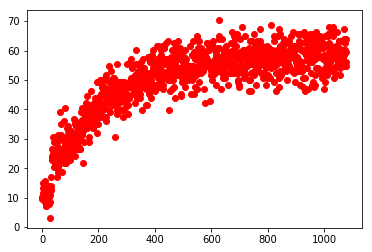

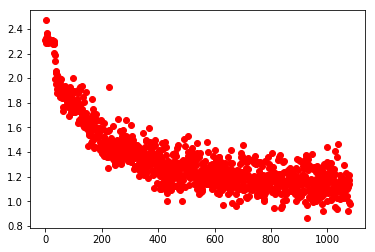

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

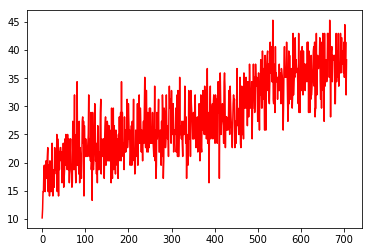

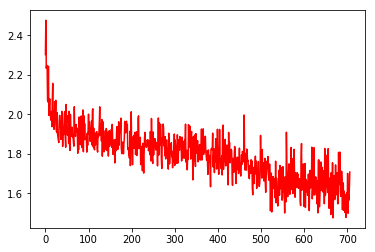

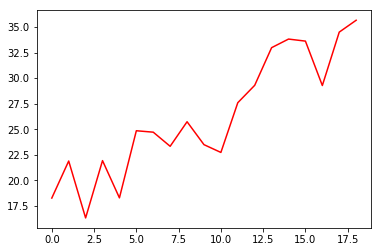

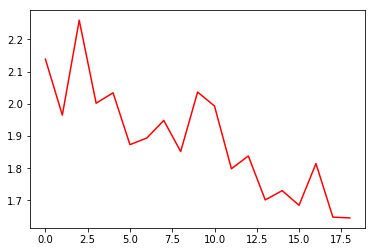

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()